# Exp.3 Train KAN with simulation data (all bit)

- Dataset: ASCADv1 simulation dataset  
    Plain/ciphertext, key, and mask are same as ASCADv1 fixed-key dataset.  
    Each sample point is derived from HW($snr$).
- PoI: 2 pts, $snr4$, $5$.
- #traces: 50,000 (profiling), 20,000 (attack)
- Preprocess: min-max mormalization to [0.0, 1.0]
- Labeling:LSB bit of unmasked SBox output (two class classification)
- Loss function: Softmax cross entropy (torch.nn.BCEWithLogitsLoss)
- Model architecture: [2(Input), 1, 2(Softmax)]  

| $snr$ # | Leakage                            |                                         |
| ---     | ---                                | ---                                     |
| 4       | Masked sbox output in linear part  | $SBox(p[3] \oplus k[3]) \oplus r[3]$    |
| 5       | Mask of Sbox output in linear part | $r[3]$                                  |

In [1]:
import torch
from pathlib import Path
import os
import hydra
import numpy as np
import matplotlib.pyplot as plt
import pickle

os.chdir('/workspace')
import src

In [2]:
def get_cfg(pos):
    with hydra.initialize(config_path="../conf", version_base='1.1'):
        cfg = hydra.compose(
            config_name='config',
            overrides=[
                "model=KAN1h",
                "model.model.width.0=2",
                "model.model.width.1=1",
                "model.model.grid=10",
                "model.train_params.steps=7000",
                "dataset@train=ASCADf_profiling",
                "dataset@test=ASCADf_attack",
                "trace_transforms=set_poi",
                "trace_transforms.transforms.0.pois=[[3,5,1]]",
                "label_transforms=bit",
                f"label_transforms.transforms.3.pos={pos}",
                f"save_path=/workspace/notebook/results/exp3/4",
                "n_attack_traces=2000"
                ]
            )
    return cfg

In [3]:
def train(cfg):
    device = hydra.utils.instantiate(cfg.device)
    cpu = torch.device('cpu')

    # Dataset
    ds_prof = hydra.utils.instantiate(cfg.train.dataset)
    ds_test = hydra.utils.instantiate(cfg.test.dataset)

    target_byte = 2
    profiling_dataset = src.datasets.ASCAD_sim.Dataset(
        ds_prof.plaintext,
        ds_prof.key,
        ds_prof.masks,
        target_byte=target_byte,
        trace_transforms=hydra.utils.instantiate(
            cfg.train.dataset.trace_transforms),
        label_transforms=hydra.utils.instantiate(
            cfg.train.dataset.label_transforms)
        )

    test_dataset = src.datasets.ASCAD_sim.Dataset(
        ds_test.plaintext,
        ds_test.key,
        ds_test.masks,
        target_byte=target_byte,
            trace_transforms=hydra.utils.instantiate(
            cfg.train.dataset.trace_transforms),
        label_transforms=hydra.utils.instantiate(
            cfg.train.dataset.label_transforms)
        )

    train_dataloader = torch.utils.data.DataLoader(
        profiling_dataset, batch_size=cfg.train.batch_size, shuffle=True
    )
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=cfg.test.batch_size, shuffle=False
    )
    KANds = src.utils.to_KAN_dataset(
        train_dataloader, test_dataloader,
        device=device)

    # Train
    model = hydra.utils.instantiate(cfg.model.model)
    if not Path(cfg.save_path, cfg.model_name+'.ckpt').exists():
        model = model.to(device)
        _ = model.train(
            KANds,
            **hydra.utils.instantiate(cfg.model.train_params)
            )
        Path(cfg.save_path).mkdir(exist_ok=True, parents=True)
        model.to(cpu).save_ckpt(cfg.model_name+'.ckpt', cfg.save_path)
    else:
        model.load_ckpt(cfg.model_name+'.ckpt', cfg.save_path)
    model = model.to(device)

    # Test
    preds, labels, th = src.utils.make_prediction(
    model, test_dataloader, device,
    cfg.label_transforms.one_hot)
    preds_class = np.argmax(preds, axis=1)
    accuracy = np.mean(labels == preds_class)
    print('Accuracy: ', accuracy)

    return model, KANds, test_dataset, test_dataloader, device

In [4]:
cfg = get_cfg(0)
model, KANds, test_dataset, test_dataloader, device = train(cfg)

train loss: 8.27e-01 | test loss: 8.31e-01 | reg: 5.52e-01 : 100%|█| 7000/7000 [03:22<00:00, 34.54it


save this model to /workspace/notebook/results/exp3_dev//KAN-1Hidden.ckpt
Accuracy:  0.5375


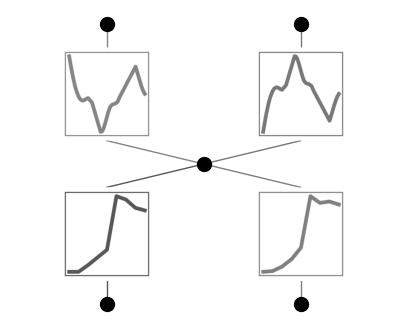

In [5]:
test_inputs = torch.tensor(
    np.array([test_dataset[v][0] for v in range(cfg.n_attack_traces)])).to(device)
_ = model(test_inputs)
model.plot(folder=cfg.save_path+'/attack')
plt.savefig(
    Path(cfg.save_path, f'{cfg.model.name}_attack.png'),
    dpi=300)
src.utils.plot_KAN(cfg, model, 'attack')

In [6]:
model.fix_symbolic(0,0,0, 'x')
model.fix_symbolic(0,1,0, 'x')

r2 is 0.7467657327651978
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 0.7735549807548523
r2 is not very high, please double check if you are choosing the correct symbolic function.


tensor(0.7736, device='cuda:0')

In [7]:
_ = model.train(
    KANds,
    **hydra.utils.instantiate(cfg.model.train_params)
    )

train loss: 8.29e-01 | test loss: 8.29e-01 | reg: 5.76e-01 : 100%|█| 7000/7000 [03:29<00:00, 33.47it


In [8]:
preds, labels, th = src.utils.make_prediction(
    model, test_dataloader, device,
    cfg.label_transforms.one_hot)

preds_class = np.argmax(preds, axis=1)
accuracy = np.mean(labels == preds_class)
print('Accuracy: ', accuracy)

Accuracy:  0.5314


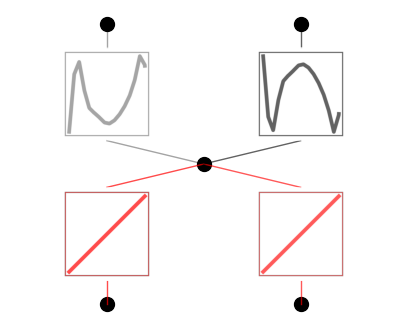

In [9]:
model(KANds['train_input'])
model.plot()